<a href="https://colab.research.google.com/github/asyagadz/Boston-Airbnb-data/blob/main/Nexo_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segmentation based on transactional data

The purpose of this notebook is to showcase an approach for customer segmentation using Nexo's transactional data /dummy data/ for three products - credit, deposit flex and deposit locked. Data is on customer /user id/ level.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import matplotlib
%matplotlib inline

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import seaborn as sns
sns.set()

import spacy
import scipy.stats as stats

import nltk

import os
# environment settings
pd.set_option('display.max_column',None)
pd.set_option('display.max_rows',None)

In [2]:
data = pd.read_csv("/content/drive/MyDrive/Nexo_task/staging_balances.csv")

In [3]:
data.shape

(6735288, 6)

In [4]:
data.head()

,snapshot_date,original_user_id,currency_short,credit_wallet_usd,savings_flex,savings_locked
0,2023-09-05,637b941bfd14236f8e413f82,BTC,0.000000,136607.274083,0.0
1,2023-09-09,64f24aa738b36256af516b1e,NEXONEXO,0.000000,16.731439,0.0
2,2023-09-10,64274d12700b504ba12d99c1,BTC,19.715409,136645.461383,0.0
3,2023-09-17,6452b09e16beba715a474773,BTC,63.097555,135651.089070,0.0
4,2023-09-19,63cd788d11022573587d9f14,BTC,0.000000,135914.498199,0.0


In [5]:
pd.options.display.float_format = '{:.2f}'.format
data.describe(include='all')

,snapshot_date,original_user_id,currency_short,credit_wallet_usd,savings_flex,savings_locked
count,6735288,6735288,6735198,6724715.00,6724715.00,6724715.00
unique,51,113030,90,NaN,NaN,NaN
top,2023-10-11,63593542047ab0e437c00bfc,BTC,NaN,NaN,NaN
freq,169551,3362,3732572,NaN,NaN,NaN
mean,NaN,NaN,NaN,215521.84,106600734345.70,1747.49
std,NaN,NaN,NaN,73892139.30,33418399012414.43,530559.84
min,NaN,NaN,NaN,-274213.26,-18627.78,-39635.18
25%,NaN,NaN,NaN,0.00,2.37,0.00
50%,NaN,NaN,NaN,0.00,9667.16,0.00
75%,NaN,NaN,NaN,70.07,135766.40,0.00


## 1. Exploratory data analysis
As a first step, I am conduncting an EDA in order to understand the different variables of the data available.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6735288 entries, 0 to 6735287
Data columns (total 6 columns):
 #   Column             Dtype  
---  ------             -----  
 0   snapshot_date      object 
 1   original_user_id   object 
 2   currency_short     object 
 3   credit_wallet_usd  float64
 4   savings_flex       float64
 5   savings_locked     float64
dtypes: float64(3), object(3)
memory usage: 308.3+ MB


In [41]:
#change the type of the snapshot date to be recognized as datetime object
data['snapshot_date']=pd.to_datetime(data['snapshot_date'], format = "%Y-%m-%d")

In [7]:
data.head()

,snapshot_date,original_user_id,currency_short,credit_wallet_usd,savings_flex,savings_locked
0,2023-09-05,637b941bfd14236f8e413f82,BTC,0.000000,136607.274083,0.0
1,2023-09-09,64f24aa738b36256af516b1e,NEXONEXO,0.000000,16.731439,0.0
2,2023-09-10,64274d12700b504ba12d99c1,BTC,19.715409,136645.461383,0.0
3,2023-09-17,6452b09e16beba715a474773,BTC,63.097555,135651.089070,0.0
4,2023-09-19,63cd788d11022573587d9f14,BTC,0.000000,135914.498199,0.0


#### Check columns for missing data

In [6]:
missing_data = {print(f'number of data points missing: {data[var].isna().sum()} for variable ', var) for var in data.columns if data[var].isna().sum()>0}
missing_data

number of data points missing: 90 for variable  currency_short
number of data points missing: 10573 for variable  credit_wallet_usd
number of data points missing: 10573 for variable  savings_flex
number of data points missing: 10573 for variable  savings_locked


{None}

There are very few missing values from Currency_short, which is a categorical variable. We could either populate the missing ones with the mode value for this user or drop them, since there are only 90 data points. If for those user ids exist other records, it is better to impute the missing ones with the mode value for each user id. <br>

Regarding the missing values for the credit, the savings_flex and the savings_locked, those are probably 0 values , given the assumption that if an user id does not have a balance for a day, for which other users have balance, this means the balance is 0. Those are important points, because this will give us a starting point for calculating the time differences in the balances.

In [55]:
data[data['currency_short'].isnull()==True].head(10)

,snapshot_date,original_user_id,currency_short,credit_wallet_usd,savings_flex,savings_locked
snapshot_date,,,,,,
2023-10-03,2023-10-03,63593542047ab0e437c00bfc,NaN,NaN,NaN,NaN
2023-10-07,2023-10-07,63593542047ab0e437c00bfc,NaN,NaN,NaN,NaN
2023-09-03,2023-09-03,5ae7efcdee34e516a50f9bce,NaN,NaN,NaN,NaN
2023-09-09,2023-09-09,63593542047ab0e437c00bfc,NaN,NaN,NaN,NaN
2023-10-05,2023-10-05,5ae7efcdee34e516a50f9bce,NaN,NaN,NaN,NaN
2023-10-11,2023-10-11,63593542047ab0e437c00bfc,NaN,NaN,NaN,NaN
2023-09-06,2023-09-06,63593542047ab0e437c00bfc,NaN,NaN,NaN,NaN
2023-09-14,2023-09-14,63593542047ab0e437c00bfc,NaN,NaN,NaN,NaN
2023-09-26,2023-09-26,63593542047ab0e437c00bfc,NaN,NaN,NaN,NaN


In [56]:
data[data['credit_wallet_usd'].isnull()==True].head(10)

,snapshot_date,original_user_id,currency_short,credit_wallet_usd,savings_flex,savings_locked
snapshot_date,,,,,,
2023-09-29,2023-09-29,62b449ee8c71d8126472baa32,NEXONEXO,NaN,NaN,NaN
2023-09-21,2023-09-21,618242f163345f737e182e45,LTC,NaN,NaN,NaN
2023-09-07,2023-09-07,635f7b1afb74d47143643bb3,BTC,NaN,NaN,NaN
2023-10-03,2023-10-03,63fcd29672b8e83cee0bd099,1INCH,NaN,NaN,NaN
2023-09-04,2023-09-04,harambaba,USDTERC,NaN,NaN,NaN
2023-09-22,2023-09-22,1234,USDTERC,NaN,NaN,NaN
2023-10-04,2023-10-04,savev_unique_id,DOT,NaN,NaN,NaN
2023-10-03,2023-10-03,632d60215fb4a71e2f181403,ETH,NaN,NaN,NaN
2023-09-10,2023-09-10,64e4b259d36f491a833e89d4,ETHW,NaN,NaN,NaN


In [57]:
data.index.max()-data.index.min()

Timedelta('315 days 00:00:00')

In [63]:
data.index.unique()

DatetimeIndex(['2023-09-05', '2023-09-09', '2023-09-10', '2023-09-17',
               '2023-09-19', '2023-09-21', '2023-09-23', '2023-09-29',
               '2023-10-04', '2023-10-06', '2023-10-07', '2023-10-09',
               '2023-10-11', '2023-09-02', '2023-09-11', '2023-09-12',
               '2023-09-13', '2023-09-16', '2023-09-22', '2023-09-24',
               '2023-09-06', '2023-09-28', '2023-10-10', '2023-09-03',
               '2023-09-15', '2023-09-26', '2023-10-03', '2023-10-05',
               '2023-09-04', '2023-09-25', '2023-10-02', '2023-09-18',
               '2023-09-20', '2023-10-08', '2023-09-30', '2023-10-01',
               '2023-09-07', '2023-09-27', '2023-09-01', '2023-09-08',
               '2023-09-14', '2023-04-30', '2023-06-30', '2023-07-31',
               '2023-08-31', '2022-11-30', '2023-03-31', '2023-05-31',
               '2023-01-31', '2023-02-28', '2022-12-31'],
              dtype='datetime64[ns]', name='snapshot_date', freq=None)

In [ ]:
``

We are using the snapshot date as datetime index, just to understand with how sparse and irregular data we are dealing with. So if we have only 51 days of records within a timespan of 315 days, and given the assumption that a user id balance is 0 only if there are other user ids with balances for this day, in order to assign a value of 0 to a user id, we need to know that another user has a balance on that day. This means that we can only add values for those 51 days.

#### Check the distributions of the variables

In [162]:
def diagnostic_plots(df, variable):
    """function takes a dataframe (df) and a continuous variable as arguments and returns the distribution of the variable of interest
    """
    plt.figure(figsize=(16, 4))
    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')
    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')
    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')
    plt.show()

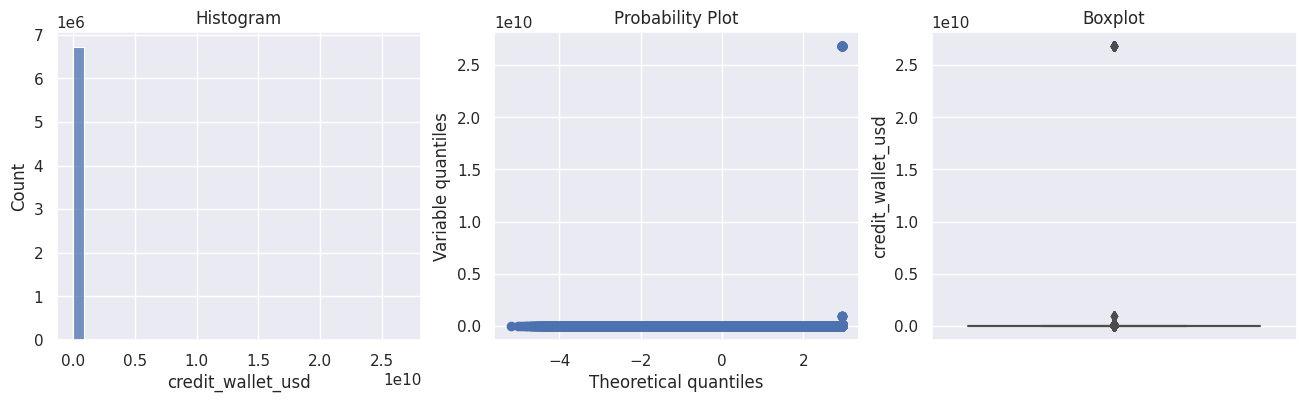

In [16]:
diagnostic_plots(data,'credit_wallet_usd')

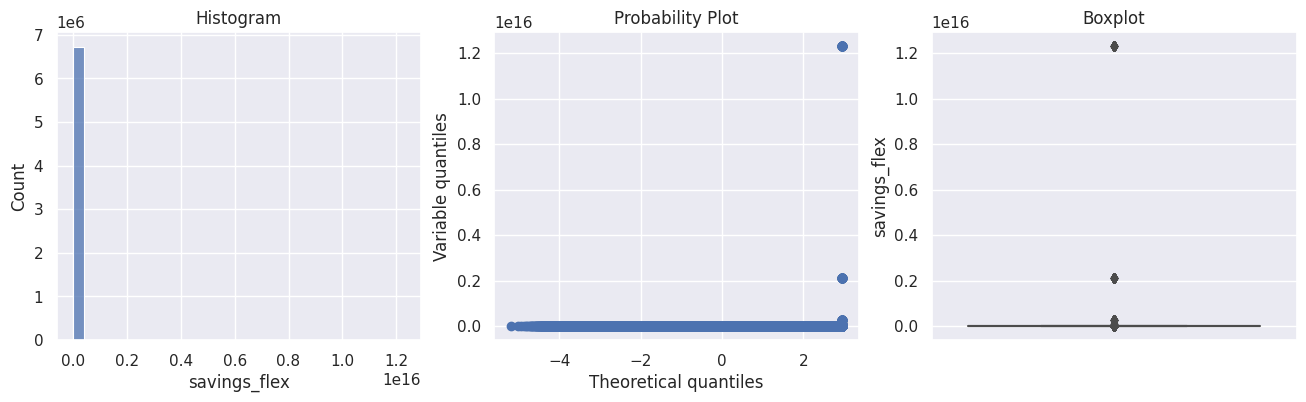

In [17]:
diagnostic_plots(data,'savings_flex')

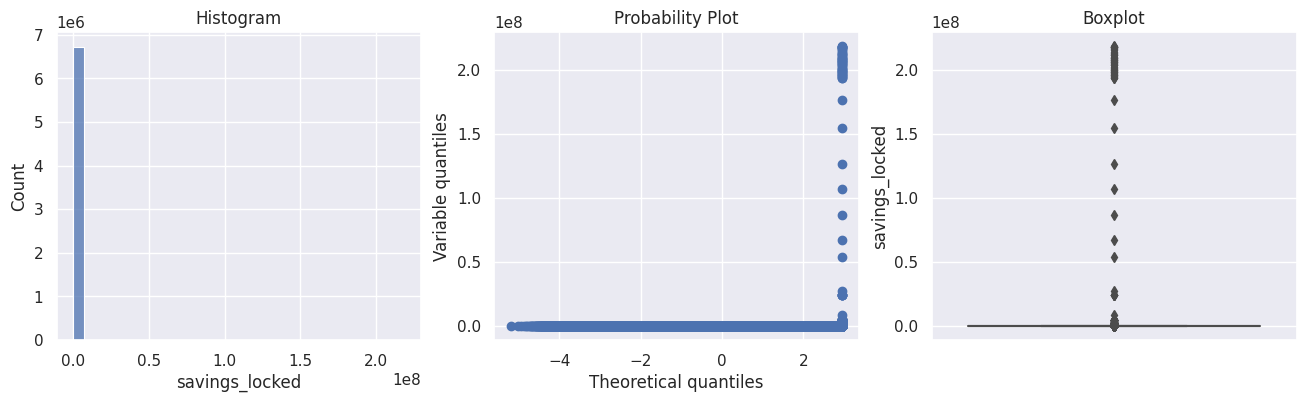

In [18]:
diagnostic_plots(data,'savings_locked')

In [22]:
data['original_user_id'].nunique()

113030

In [23]:
data.groupby(['original_user_id']).agg({'snapshot_date':'nunique'}).reset_index().head(4)

,original_user_id,snapshot_date
0,00bb4ff880d66f71c5b22acd,43
1,00db4c46a8176461c01544a8,43
2,0563440486451bf053c16f4d,21
3,088080800808,50


In [24]:
data['currency_short'].nunique()

90

In [25]:
data['currency_short'].value_counts().head(5)

BTC         3732572
NEXONEXO    1310574
USDX         606073
ETH          181927
USDTERC      176522
Name: currency_short, dtype: int64

<ipython-input-21-23ee9540e06d>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data=data.corr().round(2), annot=True)


<Axes: >

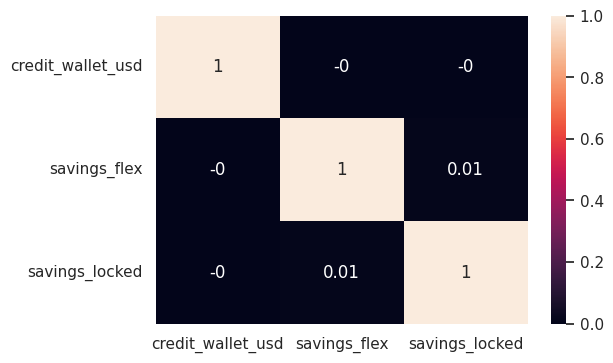

In [21]:
figure = plt.figure(figsize=(6, 4))
sns.heatmap(data=data.corr().round(2), annot=True)

In [ ]:
data.groupby(['original_user_id','snapshot_date']).count().head(10)

currency_short  credit_wallet_usd  \
original_user_id         snapshot_date                                      
00bb4ff880d66f71c5b22acd 2023-07-31                  1                  1   
                         2023-08-31                  1                  1   
                         2023-09-01                  1                  1   
                         2023-09-02                  1                  1   
                         2023-09-03                  1                  1   
                         2023-09-04                  1                  1   
                         2023-09-05                  1                  1   
                         2023-09-06                  1                  1   
                         2023-09-07                  1                  1   
                         2023-09-08                  1                  1   

                                        savings_flex  savings_locked  
original_user_id         snapshot_date                                
00bb4ff880d66f71c5b22acd 2023-07-31                1               1  
                         2023-08-31                1               1  
                         2023-09-01                1               1  
                         2023-09-02                1               1  
                         2023-09-03                1               1  
                         2023-09-04                1               1  
                         2023-09-05                1               1  
                         2023-09-06                1               1  
                         2023-09-07                1               1  
                         2023-09-08                1               1

In [ ]:
data[data['original_user_id']=='643c559199ab3d5c626d7979'].groupby(['savings_flex']).value_counts()

savings_flex   snapshot_date  original_user_id          currency_short  credit_wallet_usd  savings_locked
135631.931006  2023-04-30     643c559199ab3d5c626d7979  BTC             23.700096          0.0               1
135645.067019  2023-05-31     643c559199ab3d5c626d7979  BTC             23.700096          0.0               1
135664.786225  2023-06-30     643c559199ab3d5c626d7979  BTC             23.700096          0.0               1
               2023-07-31     643c559199ab3d5c626d7979  BTC             23.700096          0.0               1
135736.113247  2023-09-17     643c559199ab3d5c626d7979  BTC             23.700096          0.0               1
               2023-08-31     643c559199ab3d5c626d7979  BTC             23.700096          0.0               1
               2023-09-01     643c559199ab3d5c626d7979  BTC             23.700096          0.0               1
               2023-09-02     643c559199ab3d5c626d7979  BTC             23.700096          0.0               1
      

In [ ]:
data.groupby(['original_user_id']).agg({'currency_short':'nunique'}).reset_index().head(5)

,original_user_id,currency_short
0,00bb4ff880d66f71c5b22acd,1
1,00db4c46a8176461c01544a8,1
2,0563440486451bf053c16f4d,1
3,088080800808,2
4,0b9447eeb8ec05b5bb9941f4,1


Given the data specifics, any visualisations on current level are not meaningful, because we are looking at user id data, and the numerical features we have are balances, which means that aggregating them on user level and summing them is not meaningdful. __We need to construct out of the existing df metrics and measures on user id level /given the fact that we will be grouping and segmenting the users/, e.g:__
- number of currencies per user id

#### Fill-in missing values

For the 90 missing data points of currency_short, we are imputing the missing values with the most frequent currency by user id.

In [5]:
data['currency_short'] = data.groupby('original_user_id')['currency_short'].transform(lambda x: x.mode()[0])

In [6]:
data[data['currency_short'].isnull()==True].shape

(0, 6)

For the missing balances, we need to check - if there are balances for other users for those days -> then we can fill in with 0s the missing balances. If there are not -> we need to drop them. As we see, the missing data points balances are the same for all three products. If there are users with balance >0 on this particular date, so we can impute it with 0.

In [36]:
data[(data['credit_wallet_usd'].isnull()==True)&(data['savings_flex'].isnull()==True)&(data['savings_locked'].isnull()==True)].shape

(10573, 6)

In [66]:
list_days_with_balance = []
for day in days_to_check:
  if any(data[data['snapshot_date']==day]['credit_wallet_usd']>0)==True:
    list_days_with_balance.append(day)

In [70]:
# check if there are days without balance for users:
list(set(days_to_check) - set(list_days_with_balance))

[]

In [78]:
def check_days_missing_balances(var):
  """The function takes as input one of the continuous variables, and check for the days with missing values whether there is a positive balance for the respective variable.
  If there it is, this means that we can impute the missing value with 0
  """
  days_to_check = data[data[var].isnull()==True]['snapshot_date'].unique()
  list_days_with_balance = []
  for day in days_to_check:
    if any(data[data['snapshot_date']==day][var]>0)==True:
      list_days_with_balance.append(day)

  if list(set(days_to_check) - set(list_days_with_balance_2)) ==[]:
    return print (f'for {var} impute all missing values with 0')

In [80]:
for var in ['credit_wallet_usd','savings_flex','savings_locked']:
  check_days_missing_balances(var)

for credit_wallet_usd impute all missing values with 0
for savings_flex impute all missing values with 0
for savings_locked impute all missing values with 0


In [7]:
data.fillna(0,inplace=True)

In [11]:
data.isnull().sum()

snapshot_date        0
original_user_id     0
currency_short       0
credit_wallet_usd    0
savings_flex         0
savings_locked       0
dtype: int64

In [83]:
data.head()

,snapshot_date,original_user_id,currency_short,credit_wallet_usd,savings_flex,savings_locked
0,2023-09-05,637b941bfd14236f8e413f82,BTC,0.000000,136607.274083,0.0
1,2023-09-09,64f24aa738b36256af516b1e,BTC,0.000000,16.731439,0.0
2,2023-09-10,64274d12700b504ba12d99c1,BTC,19.715409,136645.461383,0.0
3,2023-09-17,6452b09e16beba715a474773,BTC,63.097555,135651.089070,0.0
4,2023-09-19,63cd788d11022573587d9f14,BTC,0.000000,135914.498199,0.0


### Construct new datetime columns for month, week

In [9]:
# Extract date and time features.
data['snapshot_date'] = pd.to_datetime(data['snapshot_date'])
data["Month"] = data['snapshot_date'].dt.month
data["Week"] = data['snapshot_date'].dt.isocalendar().week
data["Day_of_week"] = data['snapshot_date'].dt.day_of_week
data['Year']=data['snapshot_date'].dt.year
data['month']=data['snapshot_date'].apply(lambda x: strftime(x, "%Y-m"))

In [13]:
data['week_year'] = str(data['Year'])+"" +str(data['Week'])

In [21]:
data['month']=data['snapshot_date'].apply(lambda x: x.strftime("%Y-%b"))
data['week_year'] = data['snapshot_date'].apply(lambda x: x.strftime("%Y-%W"))

In [22]:
data.head()

,snapshot_date,original_user_id,currency_short,credit_wallet_usd,savings_flex,savings_locked,Month,Week,Day_of_week,Year,month,week_year
0,2023-09-05,637b941bfd14236f8e413f82,BTC,0.000000,136607.274083,0.0,9,36,1,2023,2023-Sep,2023-36
1,2023-09-09,64f24aa738b36256af516b1e,BTC,0.000000,16.731439,0.0,9,36,5,2023,2023-Sep,2023-36
2,2023-09-10,64274d12700b504ba12d99c1,BTC,19.715409,136645.461383,0.0,9,36,6,2023,2023-Sep,2023-36
3,2023-09-17,6452b09e16beba715a474773,BTC,63.097555,135651.089070,0.0,9,37,6,2023,2023-Sep,2023-37
4,2023-09-19,63cd788d11022573587d9f14,BTC,0.000000,135914.498199,0.0,9,38,1,2023,2023-Sep,2023-38


Text(0.5, 1.0, 'Total Credit Portfolio - by months')

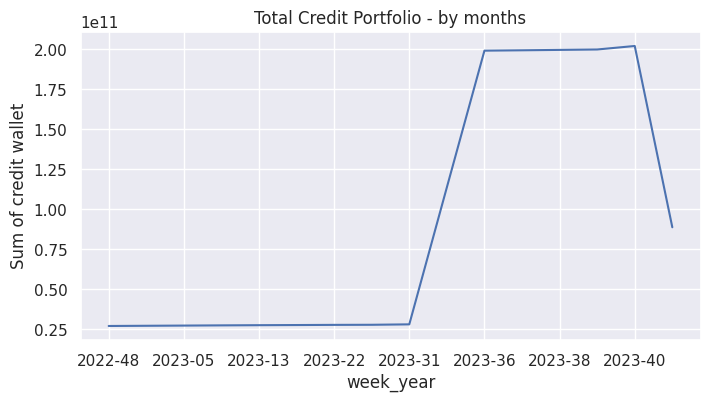

In [23]:
data.groupby(["week_year"])["credit_wallet_usd"].sum().plot(figsize=(8, 4))
plt.ylabel("Sum of credit wallet")
plt.title("Total Credit Portfolio - by months")

In [24]:
cal_week = data.groupby("week_year").agg({'original_user_id':'nunique','currency_short':'nunique'}).reset_index()

In [25]:
cal_week.head()

,week_year,original_user_id,currency_short
0,2022-48,2935,38
1,2022-52,8305,38
2,2023-05,13030,38
3,2023-09,19094,39
4,2023-13,23624,39


Text(0.5, 1.0, 'Number of unique currencies by time')

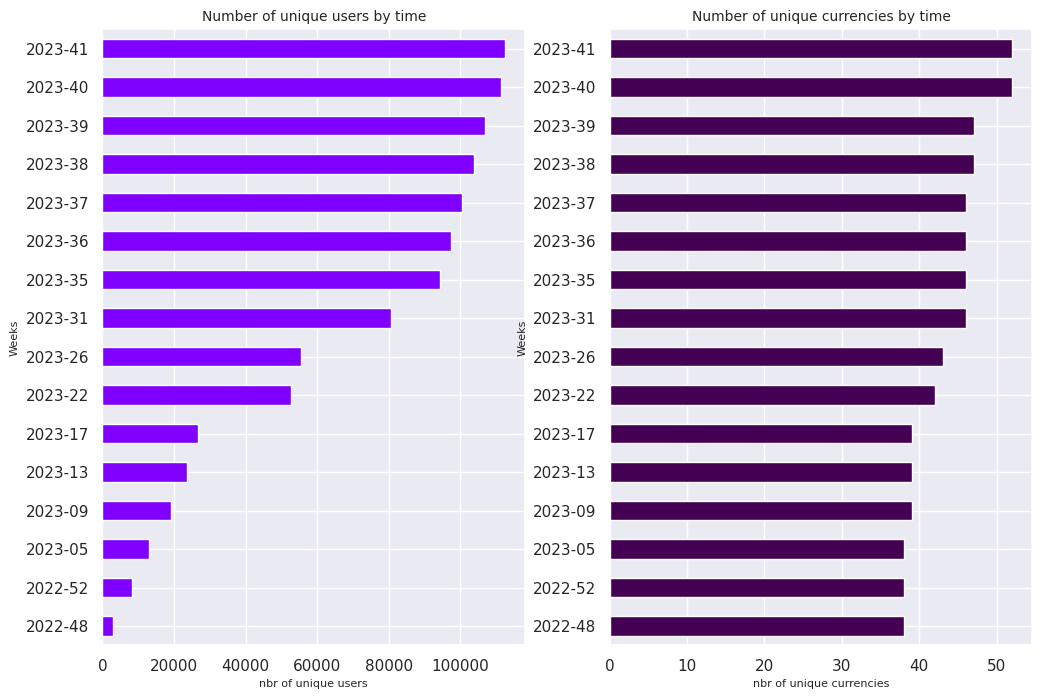

In [28]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(12,8))
ax[0]= cal_week.plot(ax=ax[0], kind='barh',x='week_year',y='original_user_id',cmap='rainbow', legend=False)
ax[0].set_ylabel('Weeks', fontsize=8)
ax[0].set_xlabel('nbr of unique users', fontsize=8)
ax[0].set_title('Number of unique users by time', fontsize=10)

ax[1]= cal_week.plot(ax=ax[1], kind='barh',x='week_year',y='currency_short',cmap='viridis', legend=False)
ax[1].set_ylabel('Weeks', fontsize=8)
ax[1].set_xlabel('nbr of unique currencies', fontsize=8)
ax[1].set_title('Number of unique currencies by time', fontsize=10)

We have monthly data, as a snapshot at the last day of the month for Nov-22 to Aug-23 and then we have daily data from 1 Sept till 11 of Sept.
We will split the df to 2 dataframes to construct monthly metrics and daily metrics. Then we will merge them back to continue with the segmentation. The idea is to be able to create monthly metrics on user level , and daily metrics on user level

In [49]:
data[["Year","Week","snapshot_date"]].value_counts()

Year  Week  snapshot_date
2023  41    2023-10-11       169551
            2023-10-10       169064
            2023-10-09       168322
      40    2023-10-08       167716
            2023-10-07       167146
            2023-10-06       164005
            2023-10-05       163128
            2023-10-04       162522
            2023-10-03       158311
            2023-10-02       157667
      39    2023-10-01       157015
            2023-09-30       156413
            2023-09-29       155734
            2023-09-28       155150
            2023-09-27       154552
            2023-09-26       153551
            2023-09-25       152855
      38    2023-09-24       152163
            2023-09-23       151519
            2023-09-22       150891
            2023-09-21       150107
            2023-09-20       149102
            2023-09-19       148064
            2023-09-18       147413
      37    2023-09-17       146823
            2023-09-16       146262
            2023-09-15       145006
  

In [45]:
# drop the users with only 0 balances on their accounts
check_users = data.groupby('original_user_id').agg({'credit_wallet_usd': 'sum', 'savings_flex':'sum','savings_locked':'sum'}).reset_index()

In [55]:
users_0_balances = list(check_users[((check_users['credit_wallet_usd']==0)&(check_users['savings_flex']==0)&(check_users['savings_locked']==0))]['original_user_id'])

In [56]:
users_0_balances

['088080800808',
 '100010101010',
 '111',
 '111111',
 '1112',
 '11122211ss',
 '123',
 '123123123',
 '1234',
 '12345678',
 '12345asdfg',
 '1331ee',
 '3123Dqwe',
 '5ea7d10e7f1c0c77227a5d221',
 '5ea7d10e7f1c0c77227a5d22_ASD_DIS',
 '6004a51cbb95553a99421f22',
 '624598b99bed15708569e681',
 '62b449ee8c71d8126472baa32',
 '632311c1939bd03be31f03b7',
 '6345479ed98106329d571000',
 '637f767d0bcd9373937f6708',
 '63bec4b500638815c042ed2b',
 '6447e7cbff1c220b33219fb5',
 '64e2617b1234df56c747e798',
 '64f672bbc3c7130184386613',
 '651291df7acd8d52e977889c',
 '6512b83cebfd9f48a9798ca9',
 '6512ba98ebfd9f48a9798cad',
 '6512bb3b4954bc06d11ff875',
 '6512c04dff5fd11703388746',
 '6512d6baa73ca50abc139893',
 '6512d8143c283370f304c4c4',
 '6512d9cdb2a72d3b935062be',
 '8688009f-440c-4698-9a61-3fd96481f5a9',
 'Demo_margin',
 'TEST11TEST',
 'TEST123',
 'a',
 'asdf3452345',
 'asdfghjkl',
 'bot3',
 'dakata_prime',
 'dfvev',
 'geadsdassdadasdsa',
 'harambaba',
 'harambe',
 'i_stole_that_platform_id_UwU',
 'pltfid12341

In [57]:
data=data[~data['original_user_id'].isin(users_0_balances)].copy()

##### Check the users with 0 balances

In [70]:
data[(data['credit_wallet_usd']==0.0)&(data['savings_flex']==0.0)&(data['savings_locked']==0.0)].shape

(2984, 12)

In [71]:
data = data[~((data['credit_wallet_usd']==0.0)&(data['savings_flex']==0.0)&(data['savings_locked']==0.0))].copy()

In [72]:
data.shape

(6723956, 12)

In [207]:
data['currency_short'].value_counts().head(4)

BTC         5304523
USDX         328955
EURX         300827
NEXONEXO     226913
Name: currency_short, dtype: int64

#### Monthly data
Take the end of each month


In [73]:
list_months = ['2022-11-30','2022-12-31','2023-01-31','2023-02-28','2023-03-31','2023-04-30','2023-05-31','2023-06-30','2023-07-31',' 2023-08-31','2023-09-30']
monthly_data= data[data['snapshot_date'].isin(list_months)].copy()

In [74]:
monthly_data.shape

(703724, 12)

In [75]:
monthly_data.head()

,snapshot_date,original_user_id,currency_short,credit_wallet_usd,savings_flex,savings_locked,Month,Week,Day_of_week,Year,month,week_year
83,2023-09-30,6410c1797257056367105b51,BTC,1962.525760,134943.956979,0.0,9,39,5,2023,2023-Sep,2023-39
96,2023-09-30,6504b92451d3ce2d7e7dcbb9,BTC,3746.607442,131870.016478,0.0,9,39,5,2023,2023-Sep,2023-39
105,2023-09-30,639579382d19d227da2adf76,BTC,19.075343,139065.108651,0.0,9,39,5,2023,2023-Sep,2023-39
106,2023-09-30,642143b90f04d239f35a56d0,BTC,0.000000,0.087875,0.0,9,39,5,2023,2023-Sep,2023-39
119,2023-09-30,64e152d6f0963c40dc0e85f3,BTC,0.000000,27219.833276,0.0,9,39,5,2023,2023-Sep,2023-39


In [208]:
monthly_data['currency_short'].describe()

count     703724
unique        47
top          BTC
freq      582675
Name: currency_short, dtype: object

In [77]:
monthly_data[monthly_data['original_user_id']=='6410c1797257056367105b51']

,snapshot_date,original_user_id,currency_short,credit_wallet_usd,savings_flex,savings_locked,Month,Week,Day_of_week,Year,month,week_year
83,2023-09-30,6410c1797257056367105b51,BTC,1962.52576,134943.956979,0.0,9,39,5,2023,2023-Sep,2023-39
6232765,2023-08-31,6410c1797257056367105b51,BTC,1962.52576,134728.193489,0.0,8,35,3,2023,2023-Aug,2023-35
6279394,2023-05-31,6410c1797257056367105b51,BTC,1962.52576,134020.159881,0.0,5,22,2,2023,2023-May,2023-22
6287310,2023-06-30,6410c1797257056367105b51,BTC,1962.52576,134020.159881,0.0,6,26,4,2023,2023-Jun,2023-26
6353377,2023-07-31,6410c1797257056367105b51,BTC,1962.52576,134502.490524,0.0,7,31,0,2023,2023-Jul,2023-31


In [78]:
monthly_data[monthly_data['original_user_id']=='6504b92451d3ce2d7e7dcbb9']

,snapshot_date,original_user_id,currency_short,credit_wallet_usd,savings_flex,savings_locked,Month,Week,Day_of_week,Year,month,week_year
96,2023-09-30,6504b92451d3ce2d7e7dcbb9,BTC,3746.607442,131870.016478,0.0,9,39,5,2023,2023-Sep,2023-39


In [79]:
monthly_data[monthly_data['original_user_id']=='64e152d6f0963c40dc0e85f3']

,snapshot_date,original_user_id,currency_short,credit_wallet_usd,savings_flex,savings_locked,Month,Week,Day_of_week,Year,month,week_year
119,2023-09-30,64e152d6f0963c40dc0e85f3,BTC,0.0,27219.833276,0.0,9,39,5,2023,2023-Sep,2023-39
6711182,2023-08-31,64e152d6f0963c40dc0e85f3,BTC,0.0,27148.977897,0.0,8,35,3,2023,2023-Aug,2023-35


In [80]:
monthly_data[(monthly_data['credit_wallet_usd']==0.0)&(monthly_data['savings_flex']==0.0)&(monthly_data['savings_locked']==0.0)].shape

(0, 12)

In [81]:
data.shape

(6723956, 12)

In [85]:
monthly_data[monthly_data['credit_wallet_usd'] == monthly_data['credit_wallet_usd'].max()]['original_user_id']

5970717    60e41b858798c461a462945d
6257524    60e41b858798c461a462945d
6290420    60e41b858798c461a462945d
6307205    60e41b858798c461a462945d
6361630    60e41b858798c461a462945d
6413435    60e41b858798c461a462945d
6475182    60e41b858798c461a462945d
6619997    60e41b858798c461a462945d
6699059    60e41b858798c461a462945d
6702844    60e41b858798c461a462945d
6714237    60e41b858798c461a462945d
Name: original_user_id, dtype: object

In [98]:
monthly_data[monthly_data['original_user_id']=='60e41b858798c461a462945d'].groupby(['snapshot_date']).agg({'credit_wallet_usd':'min','savings_flex':'min','savings_locked':'zzzzz'})


,credit_wallet_usd,savings_flex,savings_locked
snapshot_date,,,
2022-11-30,0.0,64.073791,0.0
2022-12-31,0.0,64.385278,0.0
2023-01-31,0.0,64.616481,0.0
2023-02-28,0.0,64.711923,0.0
2023-03-31,0.0,64.780182,0.0
2023-04-30,0.0,64.957993,0.0
2023-05-31,0.0,64.999096,0.0
2023-06-30,0.0,65.040224,0.0
2023-07-31,0.0,65.040224,0.0


In [94]:
monthly_data[(monthly_data['original_user_id']=='60e41b858798c461a462945d')&(monthly_data['snapshot_date']=='2023-09-30')]

,snapshot_date,original_user_id,currency_short,credit_wallet_usd,savings_flex,savings_locked,Month,Week,Day_of_week,Year,month,week_year
1559803,2023-09-30,60e41b858798c461a462945d,BTC,0.000000e+00,6.527378e+01,0.0,9,39,5,2023,2023-Sep,2023-39
3037910,2023-09-30,60e41b858798c461a462945d,BTC,0.000000e+00,1.698217e+07,0.0,9,39,5,2023,2023-Sep,2023-39
5970717,2023-09-30,60e41b858798c461a462945d,BTC,2.682881e+10,3.031221e+04,0.0,9,39,5,2023,2023-Sep,2023-39


In [99]:
monthly_data[(monthly_data['original_user_id']=='60e41b858798c461a462945d')&(monthly_data['snapshot_date']=='2023-08-31')]

,snapshot_date,original_user_id,currency_short,credit_wallet_usd,savings_flex,savings_locked,Month,Week,Day_of_week,Year,month,week_year
6314516,2023-08-31,60e41b858798c461a462945d,BTC,0.000000e+00,1.698007e+07,0.0,8,35,3,2023,2023-Aug,2023-35
6454303,2023-08-31,60e41b858798c461a462945d,BTC,0.000000e+00,6.523250e+01,0.0,8,35,3,2023,2023-Aug,2023-35
6475182,2023-08-31,60e41b858798c461a462945d,BTC,2.682881e+10,3.030542e+04,0.0,8,35,3,2023,2023-Aug,2023-35


In [105]:
pd.options.display.float_format = '{:.2f}'.format
monthly_data[(monthly_data['original_user_id']=='60e41b858798c461a462945d')&(monthly_data['snapshot_date']=='2023-06-30')]

,snapshot_date,original_user_id,currency_short,credit_wallet_usd,savings_flex,savings_locked,Month,Week,Day_of_week,Year,month,week_year
6257524,2023-06-30,60e41b858798c461a462945d,BTC,26828808126.10,30274.67,0.00,6,26,4,2023,2023-Jun,2023-26
6276375,2023-06-30,60e41b858798c461a462945d,BTC,0.00,16970298.15,0.00,6,26,4,2023,2023-Jun,2023-26
6370963,2023-06-30,60e41b858798c461a462945d,BTC,0.00,65.04,0.00,6,26,4,2023,2023-Jun,2023-26


In [209]:
summed_monthly = monthly_data.groupby(['original_user_id','snapshot_date','currency_short','Month','Week','Year' , 'month','week_year']).agg({'credit_wallet_usd':'sum','savings_flex':'sum','savings_locked':'sum'}).reset_index()

In [210]:
summed_monthly.head()

,original_user_id,snapshot_date,currency_short,Month,Week,Year,month,week_year,credit_wallet_usd,savings_flex,savings_locked
0,00bb4ff880d66f71c5b22acd,2023-07-31,BTC,7,31,2023,2023-Jul,2023-31,0.00,13560.73,0.00
1,00bb4ff880d66f71c5b22acd,2023-08-31,BTC,8,35,2023,2023-Aug,2023-35,0.00,13560.73,0.00
2,00bb4ff880d66f71c5b22acd,2023-09-30,BTC,9,39,2023,2023-Sep,2023-39,0.00,13560.73,0.00
3,00db4c46a8176461c01544a8,2023-07-31,BTC,7,31,2023,2023-Jul,2023-31,0.00,13560.73,0.00
4,00db4c46a8176461c01544a8,2023-08-31,BTC,8,35,2023,2023-Aug,2023-35,0.00,13560.73,0.00


In [211]:
summed_monthly['currency_short'].describe()

count     482037
unique        47
top          BTC
freq      408966
Name: currency_short, dtype: object

In [106]:
pd.options.display.float_format = '{:.2f}'.format
summed_monthly[summed_monthly['original_user_id']=='60e41b858798c461a462945d']

,original_user_id,snapshot_date,currency_short,Month,Week,Year,month,week_year,credit_wallet_usd,savings_flex,savings_locked
4528,60e41b858798c461a462945d,2022-11-30,BTC,11,48,2022,2022-Nov,2022-48,26828808126.10,16889057.76,0.00
4529,60e41b858798c461a462945d,2022-12-31,BTC,12,52,2022,2022-Dec,2022-52,26828808126.10,16930852.24,0.00
4530,60e41b858798c461a462945d,2023-01-31,BTC,1,5,2023,2023-Jan,2023-05,26828808126.10,16965454.13,0.00
4531,60e41b858798c461a462945d,2023-02-28,BTC,2,9,2023,2023-Feb,2023-09,26828808126.10,16978219.52,0.00
4532,60e41b858798c461a462945d,2023-03-31,BTC,3,13,2023,2023-Mar,2023-13,26828808126.10,16987343.90,0.00
4533,60e41b858798c461a462945d,2023-04-30,BTC,4,17,2023,2023-Apr,2023-17,26828808126.10,16996437.05,0.00
4534,60e41b858798c461a462945d,2023-05-31,BTC,5,22,2023,2023-May,2023-22,26828808126.10,16998537.56,0.00
4535,60e41b858798c461a462945d,2023-06-30,BTC,6,26,2023,2023-Jun,2023-26,26828808126.10,17000637.86,0.00
4536,60e41b858798c461a462945d,2023-07-31,BTC,7,31,2023,2023-Jul,2023-31,26828808126.10,17000637.86,0.00
4537,60e41b858798c461a462945d,2023-08-31,BTC,8,35,2023,2023-Aug,2023-35,26828808126.10,17010444.38,0.00


Calculate per user:
- nbr of months with credit history
- nbr of months with savings flex
- nbr of months with savings locked
- avg volume of credit wallet us per month
- avg volume of savings flex per month
- avg volume of savings locked per month
- avg changge in credit wallet, savings and savings locked per month
- avg nbr of currencies per month

In [220]:
df1 = summed_monthly[summed_monthly['credit_wallet_usd']!=0].groupby(['original_user_id','currency_short']).agg({'snapshot_date':'count','credit_wallet_usd':[np.mean, np.min, np.max],'currency_short':'nunique'}).rename(columns = {'count':'nbr_months_credit_history', 'mean':'avg_volume_credit_wallet','amin':'min_volume_credit_wallet','amax':'max_volume_credit_wallet','nunique':'nbr_of_unique_currencies_credit'}).reset_index()

In [221]:
df1.columns =  df1.columns.droplevel(0)

In [232]:
df1.columns = ['original_user_id', 'currency_short',
       'nbr_months_credit_history', 'avg_volume_credit_wallet',
       'min_volume_credit_wallet', 'max_volume_credit_wallet',
       'nbr_of_unique_currencies_credit']

In [233]:
df1.head()

,original_user_id,currency_short,nbr_months_credit_history,avg_volume_credit_wallet,min_volume_credit_wallet,max_volume_credit_wallet,nbr_of_unique_currencies_credit
0,5ae7b080ee34e57d301d2933,BTC,2,369.16,369.16,369.16,1
1,5aea0544faddec30301e35af,AVAX,5,101266.01,101266.01,101266.01,1
2,5afea9acedd3c37ce9308c3d,XRP,11,6137.25,6135.26,6157.14,1
3,5b230509bc5d111b3037f652,EOS,11,633361.25,633361.25,633361.25,1
4,5b3edc9aedd3c36af3422198,EOS,2,2.68,2.68,2.68,1


In [239]:
df1.shape

(67443, 7)

In [237]:
df1['currency_short'].value_counts()

BTC         62291
NEXONEXO      890
USDTERC       599
AXS           501
PAX           489
LUNA          451
ETH           436
USDC          351
APT           331
ADA           278
XRP           253
TUSD          219
LTC           195
EURX           45
BCH            37
NEXOBNB         9
GBPX            9
EOS             9
KSM             7
ATOM            6
HUSD            5
NEAR            4
AVAX            4
AAVE            3
TRX             3
DAI             3
BUSD            2
USDX            2
DOT             2
UST             2
APE             2
USD             1
OP              1
RUNE            1
GRT             1
LINK            1
Name: currency_short, dtype: int64

In [170]:
df1.shape

(67443, 6)

In [235]:
df2 = summed_monthly[summed_monthly['savings_flex']!=0].groupby(['original_user_id','currency_short']).agg({'snapshot_date':'count','savings_flex':[np.mean, np.min, np.max],'currency_short':'nunique'}).rename(columns = {'count':'nbr_months_savings_flex_history', 'mean':'avg_volume_savings_flex','amin':'min_volume_savings_flex','amax':'max_volume_savings_flex','nunique':'nbr_of_unique_currencies_savings_flex'}).reset_index()
df2.columns =  df2.columns.droplevel(0)
df2.columns = ['original_user_id', 'currency_short',
       'nbr_months_savings_flex_history', 'avg_volume_savings_flex',
       'min_volume_savings_flex', 'max_volume_savings_flex',
       'nbr_of_unique_currencies_savings_flex']

In [238]:
df2['currency_short'].value_counts()

BTC         81353
USDX         7754
NEXONEXO     3225
EURX         2916
AXS          1327
ETH           866
NEAR          851
USDTERC       527
PAX           515
APT           479
GBPX          341
EUR           187
USD           175
ADA           117
BCH            69
USDC           49
LUNA           36
XRP            31
EOS            18
LTC            17
TRX            14
KSM            14
TUSD           13
ATOM           12
XLM            11
AAVE            9
NEXOBNB         8
DAI             8
AVAX            7
UST             7
DOT             6
PAXG            4
HUSD            4
LINK            4
FLR             3
FTM             2
SOL             2
DOGE            2
BUSD            2
APE             2
MANA            2
SUSHI           1
SAND            1
NEXO            1
RUNE            1
OP              1
GRT             1
Name: currency_short, dtype: int64

In [236]:
df3 = summed_monthly[summed_monthly['savings_locked']!=0].groupby(['original_user_id','currency_short']).agg({'snapshot_date':'count','savings_locked':[np.mean, np.min, np.max],'currency_short':'nunique'}).rename(columns = {'count':'nbr_months_savings_locked_history', 'mean':'avg_volume_savings_locked','amin':'min_volume_savings_locked','amax':'max_volume_savings_locked','nunique':'nbr_of_unique_currencies_savings_locked'}).reset_index()
df3.columns =  df3.columns.droplevel(0)
df3.columns = ['original_user_id', 'currency_short','nbr_months_savings_locked_history','avg_volume_savings_locked','min_volume_savings_locked',
               'max_volume_savings_locked','nbr_of_unique_currencies_savings_locked']
df3.head()

,original_user_id,currency_short,nbr_months_savings_locked_history,avg_volume_savings_locked,min_volume_savings_locked,max_volume_savings_locked,nbr_of_unique_currencies_savings_locked
0,5ae7ab70ee34e575ee5c935b,DOT,5,410.71,410.71,410.71,1
1,5e3078ddce1cb773642d0c3d,BTC,11,1598.07,1598.07,1598.07,1
2,5e4ba64f5901963ec77d8421,AXS,5,6427.30,6427.30,6427.30,1
3,5ea7d10e7f1c0c77227a5d22,ADA,6,995802.51,485376.73,1114158.62,1
4,5facf83665281b52062833c0,BTC,9,1066001.49,1066001.49,1066001.49,1


In [240]:
df1.shape

(67443, 7)

In [241]:
df2.shape

(100995, 7)

In [242]:
df3.shape

(2104, 7)

In [243]:
master_df = df2.merge(df1, how = 'outer', on = 'original_user_id')

In [249]:
master_df[master_df['nbr_months_savings_flex_history'].isna()==True].shape

(0, 22)

In [245]:
master_df = master_df.merge(df3, how = 'outer', on = 'original_user_id')

In [250]:
master_df.shape

(106936, 22)

In [251]:
master_df.fillna(0, inplace=True)

In [248]:
master_df['change_volume_savings_flex'] = master_df['max_volume_savings_flex'] - master_df['max_volume_savings_flex']
master_df['change_volume_savings_locked'] = master_df['max_volume_savings_locked'] - master_df['max_volume_savings_locked']
master_df['change_volume_credit_wallet'] = master_df['max_volume_credit_wallet'] - master_df['max_volume_credit_wallet']

In [159]:
master_df.head()

,original_user_id,nbr_months_savings_flex_history,avg_volume_savings_flex,min_volume_savings_flex,max_volume_savings_flex,nbr_of_unique_currencies_savings_flex,nbr_months_credit_history,avg_volume_credit_wallet,min_volume_credit_wallet,max_volume_credit_wallet,nbr_of_unique_currencies_credit,nbr_months_savings_locked_history,avg_volume_savings_locked,min_volume_savings_locked,max_volume_savings_locked,nbr_of_unique_currencies_savings_locked,change_volume_savings_flex,change_volume_savings_locked,change_volume_credit_wallet
0,00bb4ff880d66f71c5b22acd,3.00,13560.73,13560.73,13560.73,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,00db4c46a8176461c01544a8,3.00,13560.73,13560.73,13560.73,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0563440486451bf053c16f4d,1.00,13560.73,13560.73,13560.73,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0b9447eeb8ec05b5bb9941f4,3.00,13560.73,13560.73,13560.73,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0ddc4509a2cbff9a7d1e29f0,1.00,13560.73,13560.73,13560.73,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [252]:
master_df['nbr_of_unique_currencies_savings_flex'].value_counts()

1.00    100995
0.00      5941
Name: nbr_of_unique_currencies_savings_flex, dtype: int64

In [253]:
master_df['original_user_id'].nunique()

106936

#### Calculate daily metrics for users for the period between 01/09/2023-11/10/2023 with daily data + Frequency, recency:
- nbr of days from last transaction /as of 12.10.2023/
- avg nbr of days with/without transactions
- avg nbr of days between transactions
- avg volume of

In [ ]:
 df.groupby('healthCode')['createdOn'].apply(lambda days: days.max() - days.min())